In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-whitegrid")

from scipy.stats import gaussian_kde

In [3]:
class Data_description(object):
    '''
    '''
    def __init__(self, df, label_ind = None, label_name = None):
        self.df = df
        self.n_features = len(df.columns) - 1 # 라벨 벡터가 하나겠죠..?
        self.n_samples = df.shape[0]

        if type(label_ind) == int:
            self.label_ind = label_ind
        elif type(label_name) == str:
            self.label_ind = self.df.columns.get_loc(label_name)

        self.label_value = np.unique(self.df.iloc[:, self.label_ind])

        label_ratio = np.zeros(shape = len(self.label_value), dtype = float)
        for i, label in enumerate(self.label_value):
            label_ratio[i] = np.sum(np.where(self.df.iloc[:,self.label_ind] == label, 1, 0)) / self.n_samples
        self.label_ratio = label_ratio

    
    def describe(self, quantile = [0.25, 0.5, 0.75]):
        df = self.df.drop(self.df.columns[self.label_ind], axis = 1)

        self.count = df.count()
        self.nan_count = df.isna().sum(axis =0)
        
        self.mean = df.mean(axis = 0) 
        self.variance = df.var(axis = 0)
        self.median = df.median()
        self.max = df.max()
        self.min = df.min()
        self.range = self.max - self.min
        
        self.quantile = df.quantile(q = quantile, )
        quantile_names = [f"Quantile[{str(i*100)}%]" for i in quantile]
        self.quantile.index = quantile_names
        
        self.describe_df = pd.concat([pd.DataFrame({'count': self.count,
                                        'Na_count': self.nan_count,
                                        'mean': self.mean,
                                        'variance': self.variance,
                                        'median': self.median,
                                        'max': self.max,
                                        'min': self.min,
                                        'range': self.range}), self.quantile.T], axis = 1)

        return self.describe_df

    
    # 이산형(Discrete)인지 연속형(Continuous)인지 판단
    def infer_variable_type(self, unique_val_ratio = 0.05):
        df = self.df.drop(self.df.columns[self.label_ind], axis = 1)
        self.variable_type = np.empty(shape = self.n_features, dtype = object)

        for i in range(self.n_features):
            if len(np.unique(df.iloc[:, i])) / len(df.iloc[:, i]) < unique_val_ratio:
                self.variable_type[i] = "Discrete"
            else: 
                self.variable_type[i] = "Continuous"
        return self.variable_type

    
    def kde(self, standard_scale = False, min_max_scale = False, figsize = (5,4), h = 1000, color_list = ["red", "blue", "green", "orange", "purple"],
            cmap = 'viridis'):
        
        df = self.df.drop(self.df.columns[self.label_ind], axis = 1)

        method = None
        if standard_scale == True:
            df = (df - df.mean(axis = 0)) / np.sqrt(df.var(axis = 0))
            method = "Standard"
        
        if min_max_scale == True:
            df = (df - df.min()) / (df.max() - df.min())
            method = "Min_Max"
        

        self.kde_arr = np.empty(shape = self.n_features, dtype = object)
        for ind, feature in enumerate(df.columns):
            self.kde_arr[ind] = gaussian_kde(dataset = df[feature])
            
        plt.figure(figsize = figsize)
        x = np.linspace(start = df.min().min() - 1, stop = df.max().max() + 1, num = h)

        if self.n_features <= len(color_list):
            for i in range(self.n_features):
                plt.plot(x, self.kde_arr[i](x), color = color_list[i], alpha = 0.5, label = df.columns[i])
        else: 
            cmap_ = plt.get_cmap(cmap)
            for i in range(self.n_features):
                cmap_color = cmap_(i / self.n_features)
                plt.plot(x, self.kde_arr[i](x), color = cmap_color, alpha = 0.5, label = df.columns[i])
            
        plt.legend(loc = "upper right")
        plt.title(f"KDE[scaled = {method}]")
        plt.show()

    
    def hist(self, bins, layout, figsize):
        df = self.df.drop(self.df.columns[self.label_ind], axis = 1)
        df.hist(bins = bins, layout = layout, figsize = figsize, color = "gray")
        plt.show()

    
    def scatter(self, figsize, subplot_nrow, subplot_ncol, color_list = ["red", "blue", "green", "orange", "purple"]):
        df = self.df.drop(self.df.columns[self.label_ind], axis = 1)

        plt.figure(figsize = figsize)
        subplot_ind = 1
        for i in range(self.n_features):
            for j in range(i+1, self.n_features):
                plt.subplot(subplot_nrow, subplot_ncol, subplot_ind)
                
                for ind, label in enumerate(self.label_value):
                    cond = (self.df.iloc[:, self.label_ind] == label)
                    plt.scatter(x = df.loc[cond, df.columns[i]], y = df.loc[cond, df.columns[j]], s = 10, c = color_list[ind], 
                                label = f"label[{label}]", alpha = 0.5)

                
                plt.xlabel(df.columns[i])
                plt.ylabel(df.columns[j])
                plt.legend(loc = "upper right")

                subplot_ind += 1
        plt.tight_layout()
        plt.show()
    
    def cov_matrix(self):
        X = np.array(self.df.drop(self.df.columns[self.label_ind], axis = 1))
        X_tilde = X - np.mean(a = X, axis = 0)

        cov_matrix = np.empty(shape = (self.n_features, self.n_features), dtype = float)
        for i in range(self.n_features):
            for j in range(i, self.n_features):
                cov_matrix[i,j] = np.mean(X_tilde[:,i] * X_tilde[:,j])
                if i != j:
                    cov_matrix[j,i] = cov_matrix[i,j]
        return cov_matrix

    
    def corr_matrix(self):
        X = np.array(self.df.drop(self.df.columns[self.label_ind], axis = 1))
        X_tilde = X - np.mean(a = X, axis = 0)

        cov_matrix = np.empty(shape = (self.n_features, self.n_features), dtype = float)
        for i in range(self.n_features):
            for j in range(i, self.n_features):
                cov_matrix[i,j] = np.mean(X_tilde[:,i] * X_tilde[:,j]) / (np.std(X_tilde[:,i]) * np.std(X_tilde[:,j]))
                if i != j:
                    cov_matrix[j,i] = cov_matrix[i,j]
        return cov_matrix

In [148]:
file_path = r"C:\Users\user\Downloads\dataset\wine.dat"

wine_df = pd.read_csv(file_path, sep=r'\s+', header=None)
wine_df 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740,3
174,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750,3
175,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835,3
176,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840,3


In [191]:
columns_list = [f"feature{i}" for i in range(1,len(wine_df.columns))]
columns_list.append("label")

wine_df.columns = columns_list
wine_df.head(n = 10)

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,label
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1
5,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450,1
6,14.39,1.87,2.45,14.6,96,2.50,2.52,0.30,1.98,5.25,1.02,3.58,1290,1
7,14.06,2.15,2.61,17.6,121,2.60,2.51,0.31,1.25,5.05,1.06,3.58,1295,1
8,14.83,1.64,2.17,14.0,97,2.80,2.98,0.29,1.98,5.20,1.08,2.85,1045,1
9,13.86,1.35,2.27,16.0,98,2.98,3.15,0.22,1.85,7.22,1.01,3.55,1045,1


In [132]:
wine_discribe = Data_description(df = wine_df, label_name = "label")

In [134]:
print(f"wine데이터 셋의 샘플 개수: {wine_discribe.n_samples}")
print(f"wine데이터 셋의 유니크한 라벨 값: {wine_discribe.label_value}")
print(f"wine데이터 셋의 라벨 비율: {wine_discribe.label_ratio}")
print(f"wine데이터 셋 변수 유형: {wine_discribe.infer_variable_type()}")

wine데이터 셋의 샘플 개수: 178
wine데이터 셋의 유니크한 라벨 값: [1 2 3]
wine데이터 셋의 라벨 비율: [0.33146067 0.3988764  0.26966292]
wine데이터 셋 변수 유형: ['Continuous' 'Continuous' 'Continuous' 'Continuous' 'Continuous'
 'Continuous' 'Continuous' 'Continuous' 'Continuous' 'Continuous'
 'Continuous' 'Continuous' 'Continuous']


In [150]:
wine_discribe.describe()

,count,Na_count,mean,variance,median,max,min,range,Quantile[25.0%],Quantile[50.0%],Quantile[75.0%]
feature1,178,0,13.000618,0.659062,13.050,14.83,11.03,3.80,12.3625,13.050,13.6775
feature2,178,0,2.336348,1.248015,1.865,5.80,0.74,5.06,1.6025,1.865,3.0825
feature3,178,0,2.366517,0.075265,2.360,3.23,1.36,1.87,2.2100,2.360,2.5575
feature4,178,0,19.494944,11.152686,19.500,30.00,10.60,19.40,17.2000,19.500,21.5000
feature5,178,0,99.741573,203.989335,98.000,162.00,70.00,92.00,88.0000,98.000,107.0000
feature6,178,0,2.295112,0.391690,2.355,3.88,0.98,2.90,1.7425,2.355,2.8000
feature7,178,0,2.029270,0.997719,2.135,5.08,0.34,4.74,1.2050,2.135,2.8750
feature8,178,0,0.361854,0.015489,0.340,0.66,0.13,0.53,0.2700,0.340,0.4375
feature9,178,0,1.590899,0.327595,1.555,3.58,0.41,3.17,1.2500,1.555,1.9500
feature10,178,0,5.058090,5.374449,4.690,13.00,1.28,11.72,3.2200,4.690,6.2000


<Axes: >

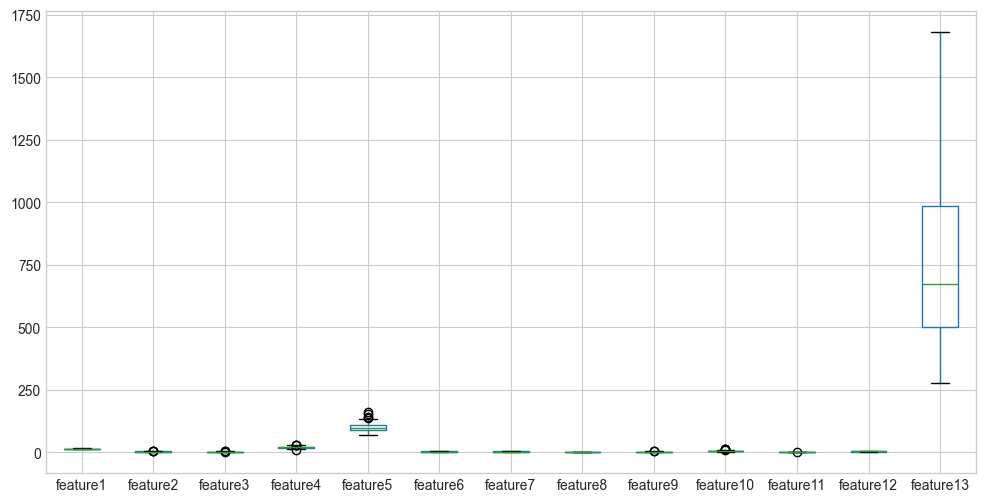

In [233]:
wine_df.boxplot(column = [f"feature{i}" for i in range(1,14)], figsize = (12,6))

<Axes: >

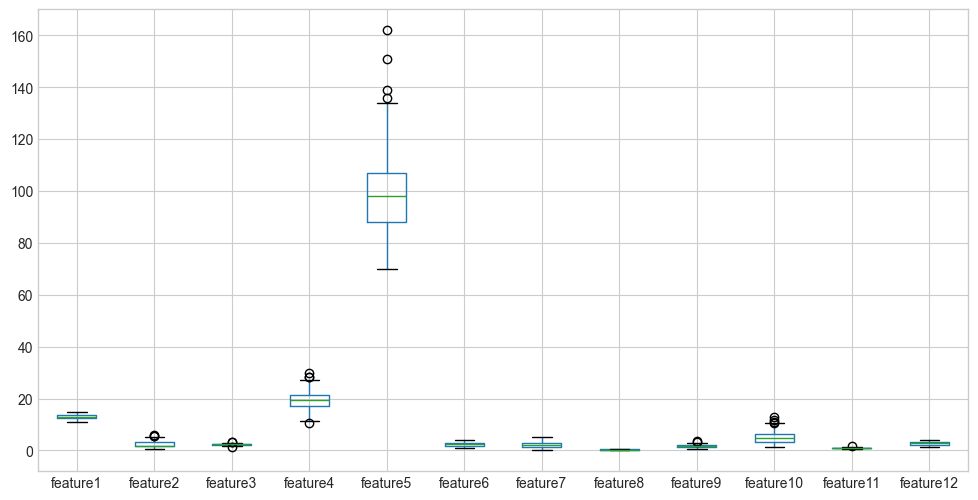

In [235]:
wine_df.boxplot(column = [f"feature{i}" for i in range(1,13)], figsize = (12,6))

<Axes: >

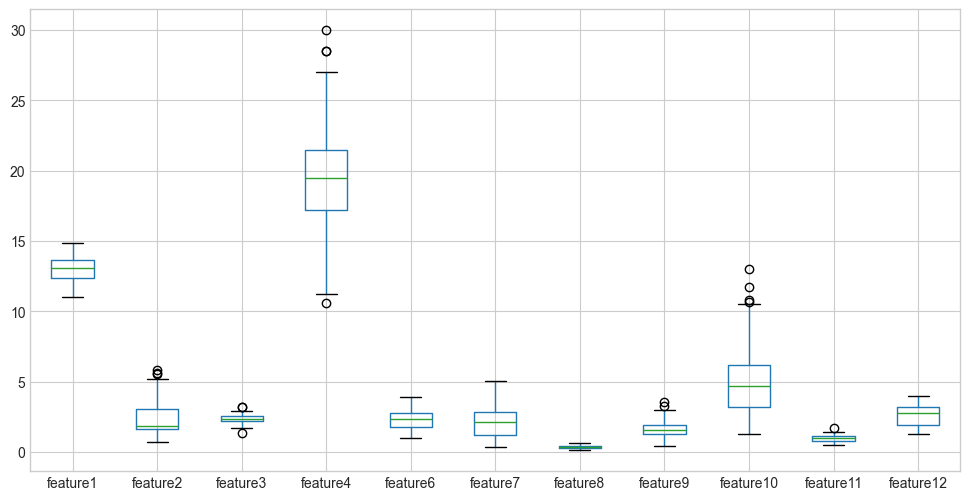

In [237]:
wine_df.boxplot(column = [f"feature{i}" for i in [1,2,3,4,6,7,8,9,10,11,12]], figsize = (12,6))

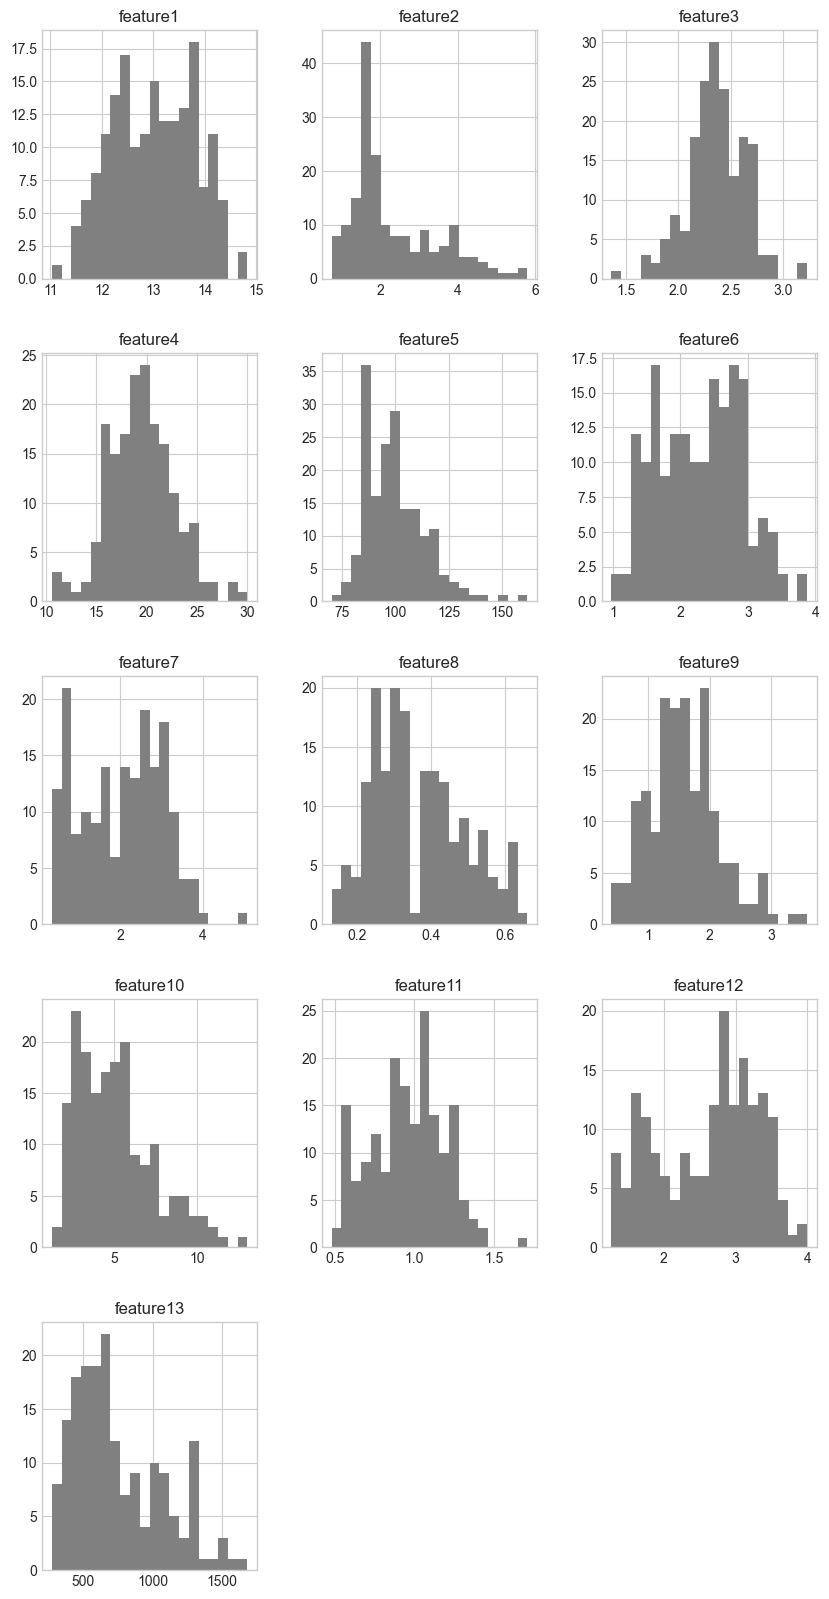

In [322]:
wine_discribe.hist(bins = 20, layout = (5,3), figsize = (10,20))

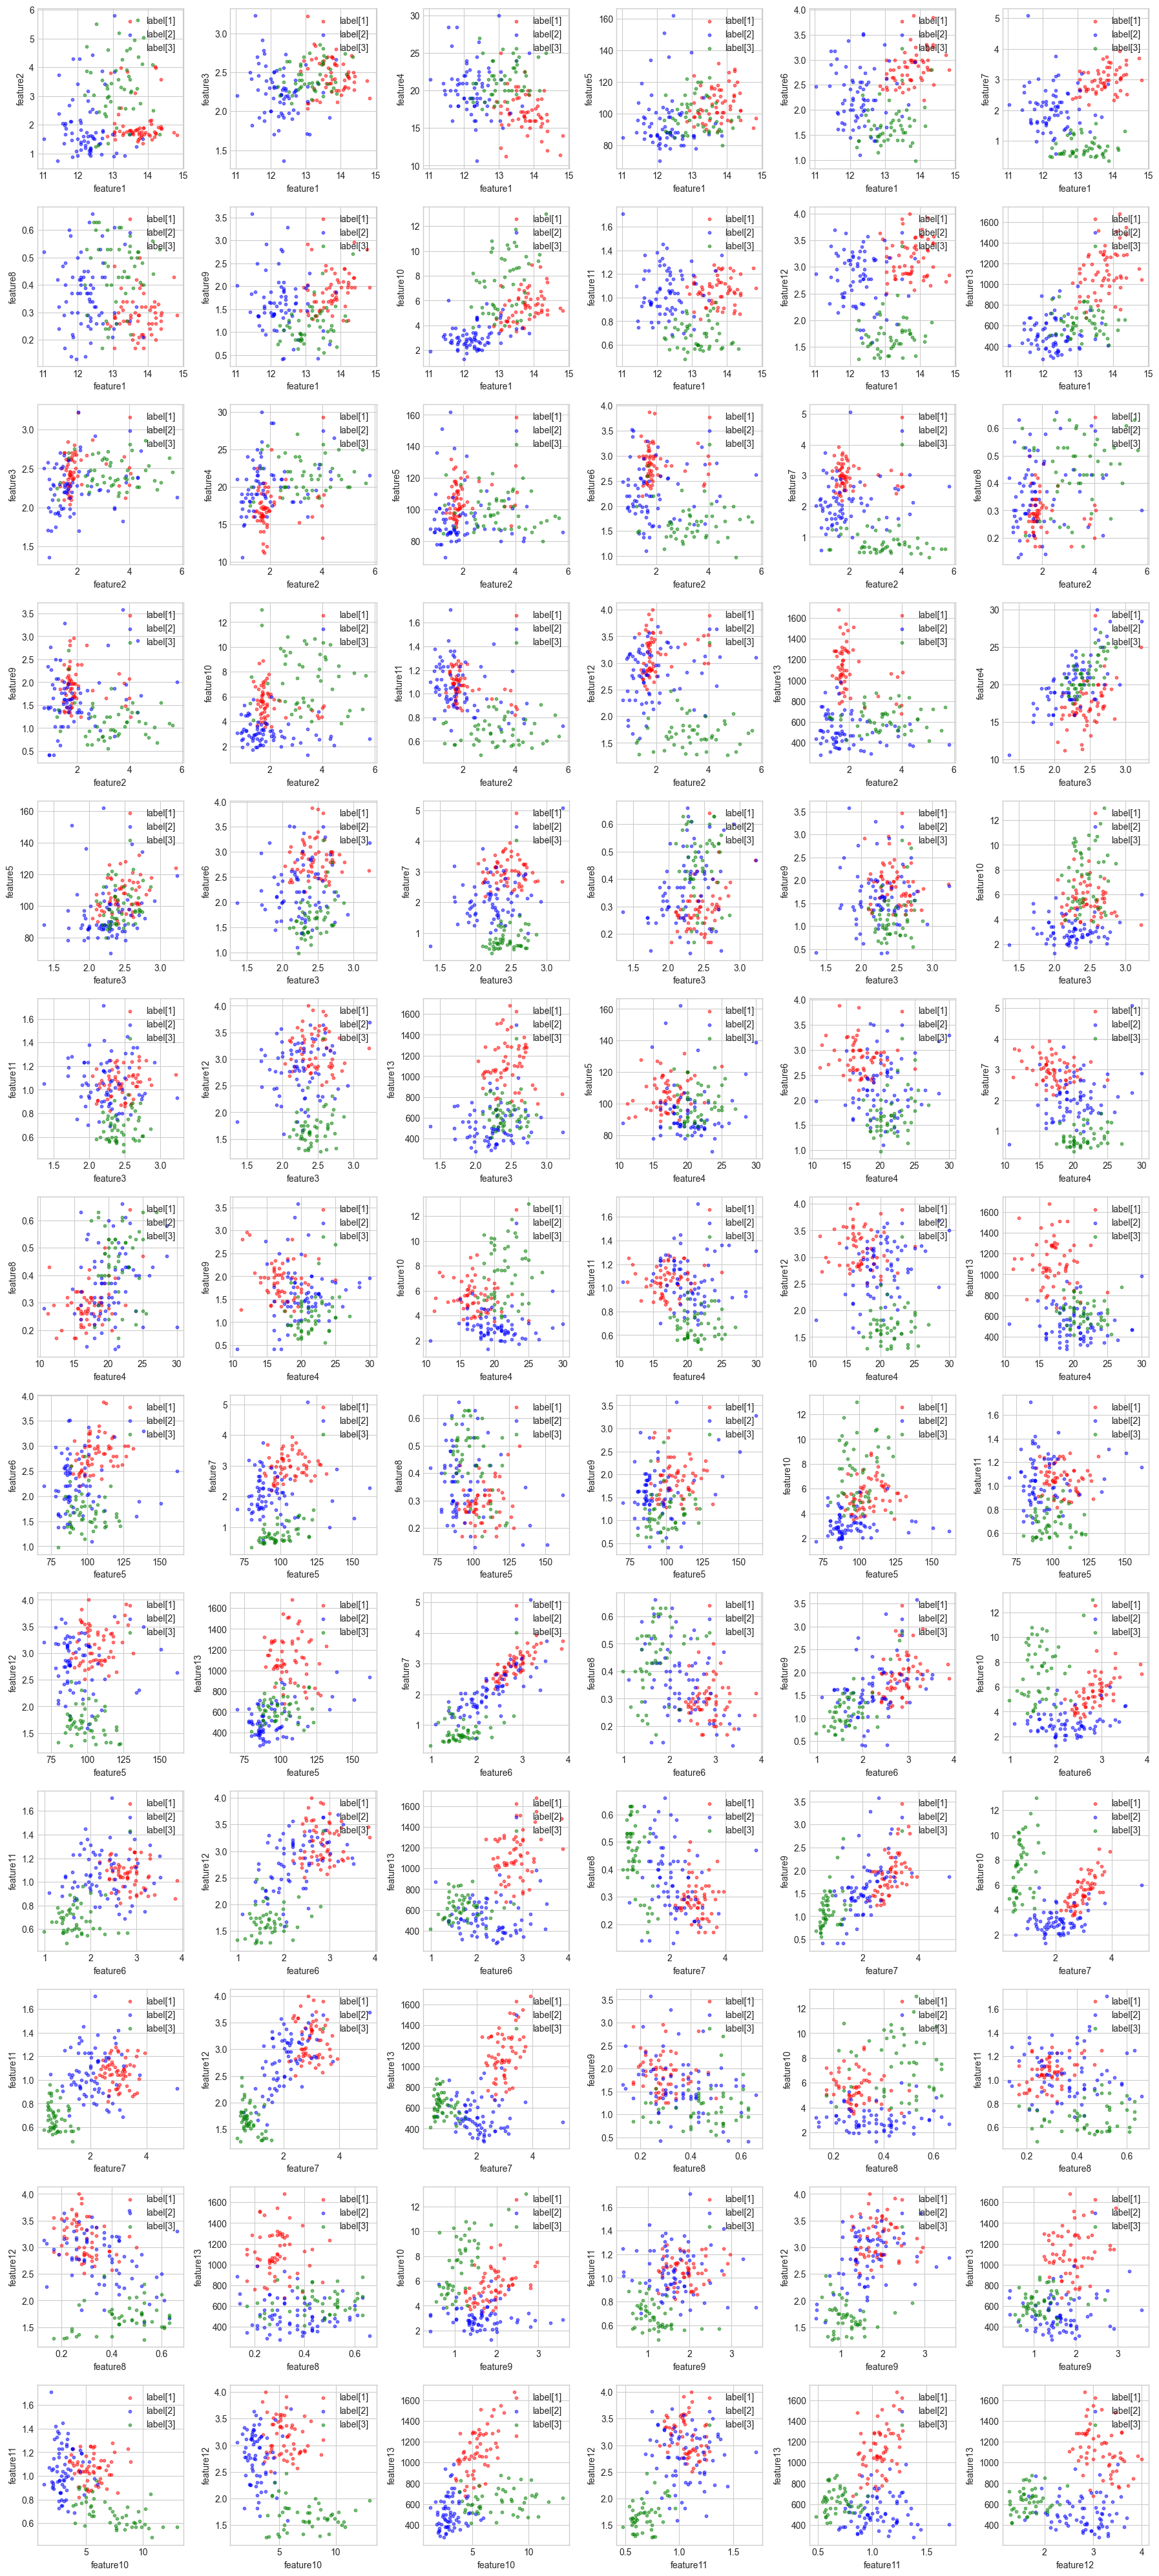

In [246]:
wine_discribe.scatter(figsize = (18,40) , subplot_ncol=6, subplot_nrow=13)

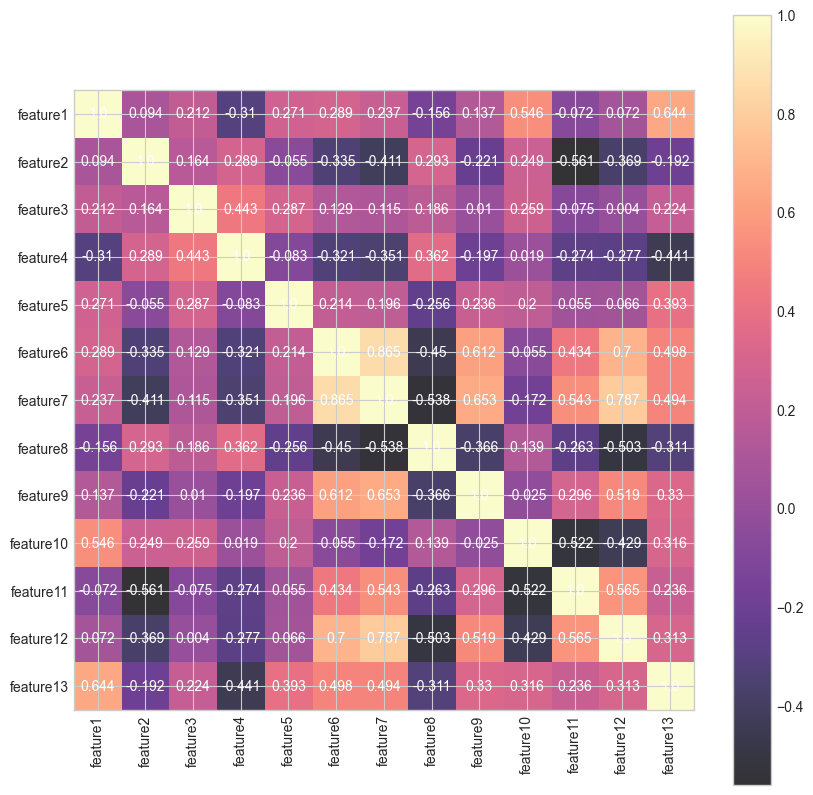

In [310]:
plt.figure(figsize = (10,10))
corr_matrix = wine_discribe.corr_matrix().round(decimals = 3)
plt.imshow(X = corr_matrix, cmap = "magma", alpha = 0.8, )
plt.colorbar()

n = 13
for i in range(n):
    for j in range(n):
        plt.text(j, i, str(corr_matrix[i, j]), 
                 ha='center', va='center', color='white', fontsize=10)

wine_drop_label = wine_df.drop("label", axis = 1)
plt.xticks(range(n), wine_drop_label.columns, rotation=90)
plt.yticks(range(n), wine_drop_label.columns)

plt.show()